In [1]:
# Import libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob

# # Consider adding the following from Ben Smith's tutorial
# import os
# import h5py
# from glob import glob
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.signal
## data_dir='ATL06/Byrd_glacier_rel001/'

import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)


# # make sure we're dealing with the most recent version of any code we're using
# %load_ext autoreload
# %autoreload 2

In [2]:
# Establish directories
data_dir = '/home/jovyan/data/'

In [3]:
fns = []

# Get the filenames and append to a list
for f in glob.glob(data_dir + "*.h5"):
    # append full filename to list of filenames
    fns.append(f)  

# sort the list
fns.sort()
fns

['/home/jovyan/data/processed_ATL06_20181110092841_06530106_001_01.h5',
 '/home/jovyan/data/processed_ATL06_20181115210428_07370102_001_01.h5',
 '/home/jovyan/data/processed_ATL06_20181213075606_11560106_001_01.h5',
 '/home/jovyan/data/processed_ATL06_20181214194017_11790102_001_01.h5',
 '/home/jovyan/data/processed_ATL06_20190111063212_02110206_001_01.h5',
 '/home/jovyan/data/processed_ATL06_20190112181620_02340202_001_01.h5',
 '/home/jovyan/data/processed_ATL06_20190209050825_06530206_001_01.h5',
 '/home/jovyan/data/processed_ATL06_20190214164413_07370202_001_01.h5']

In [4]:
# Specify the last HDF5 file from the list as a test case
myfile_fn = fns[-1]
myfile_fn

'/home/jovyan/data/processed_ATL06_20190214164413_07370202_001_01.h5'

In [5]:
# # Inspect metadata with Fernando Paolo's python function

# def print_attrs(name, obj):
#     print(name)
#     for key,val in obj.attrs.items():
#         print("    %s: %s" % (key, val))
     

In [6]:
# # This outputs a whole lot of metadata
# f = h5py.File(myfile_fn, 'r')  # keep it open in read mode

# # Inspect base groups quickly
# print(f.keys())

# # print attributes using previously-defined function
# f.visititems(print_attrs)   

# f.close()

In [7]:
# From Ben Smith's Clouds and data quality tutorial - read datasets from ATL06

# Already imported these
# import numpy as np
# import h5py


def ATL06_to_dict(filename, dataset_dict):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a list of numpy arrays containing the 
                data
    """
    
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']
    # open the HDF5 file
    with h5py.File(filename) as h5f:
        # loop over beam pairs
        for pair in pairs:
            # loop over beams
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                # loop over the groups in the dataset dictionary
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # since a dataset may not exist in a file, we're going to try to read it, and if it doesn't work, we'll move on to the next:
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                bad=temp[dataset]==fill_value
                                temp[dataset]=np.float64(temp[dataset])
                                temp[dataset][bad]=np.NaN
#                                 temp[dataset][temp[dataset]==fill_value]=np.NaN
                        except KeyError as e:
                            pass
                if len(temp) > 0:
                    # it's sometimes convenient to have the beam and the pair as part of the output data structure: This is how we put them there.
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

In [8]:
dataset_dict={'land_ice_segments':['h_li', 'delta_time','longitude','latitude'], 'land_ice_segments/ground_track':['x_atc']}

In [9]:
%matplotlib inline

# read ATL06 into a dictionary (the ATL06 file has the same name as the ATL03 file, except for the product name)
ATL06_file=myfile_fn
D6_list=ATL06_to_dict(ATL06_file, dataset_dict)

# pick out gt1r:
D6 = D6_list[0]
D6

{'h_li': array([1530.64599609, 3307.91796875, 2306.33911133, 2505.00048828,
        3636.8203125 , 2968.45849609, 1503.46569824,           nan]),
 'delta_time': array([35398039.73191596, 35398040.42400425, 35398040.95869727,
        35398041.82985646, 35398042.57480651, 35398042.72080849,
        35398044.12327225, 35398044.32623106]),
 'longitude': array([-108.13152898, -108.13685697, -108.14114858, -108.14801456,
        -108.1538202 , -108.1550304 , -108.16626967, -108.16786173]),
 'latitude': array([38.88607145, 38.93011675, 38.96426221, 39.0198018 , 39.06725742,
        39.0765997 , 39.166096  , 39.17903766]),
 'pair': array([1., 1., 1., 1., 1., 1., 1., 1.]),
 'beam': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'filename': '/home/jovyan/data/processed_ATL06_20190214164413_07370202_001_01.h5'}

In [11]:
# # plot ATL06:
# f1,ax = plt.subplots(num=1)
# ax.plot(D6['x_atc'], D6['h_li'],'b.', markersize=4, label='ATL06')
# lgd = ax.legend(loc=3,frameon=False)

# ax.set_xlabel('h_li, m')
# ax.set_ylabel('h, m')
# plt.show()


In [ ]:
num_bad_segments=np.sum((D6['x_atc'] > 2.904e7) & (D6['x_atc'] < 2.912e7) & np.isfinite(D6['h_li']))
num_possible_segments=(2.912e7 - 2.904e7)/20
F_bad=num_bad_segments/num_possible_segments
print("fraction of bad segments = %3.3f" % F_bad)

### Plot of all 14 granules

read 44 beam/pair combinations


FigureCanvasNbAgg()

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/srv/conda/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


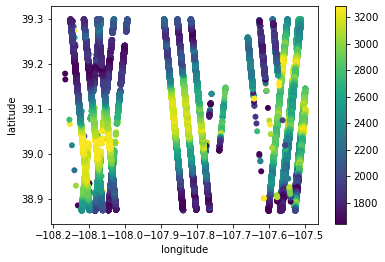

In [12]:
%matplotlib widget

D6=[]
pairs=[1, 2, 3]
beams=['l','r']

files=glob.glob(data_dir+'/*.h5')
for file in files:
    this_name=os.path.basename(file)
    D6 += ATL06_to_dict(file, dataset_dict)
print("read %d beam/pair combinations" % (len(D6)))

# now plot the results:
plt.figure();
for Di in D6:
    plt.scatter(Di['longitude'], Di['latitude'], c=Di['h_li'], 
                #vmin=0, vmax=2000, 
                linewidth=0)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()